# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [79]:
DATA_FOLDER = '../thermography/data/'

FILES = 24
TRAINING_FILES = 16
TEST_FILES = FILES - TRAINING_FILES

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [81]:
# Normalization
def scale(data):
    min_ = np.min(data)
    max_ = np.max(data)
    mean = (max_ + min_) / 2.0
    range_ = (max_ - min_) / 2.0
    data = (data - mean)/range_
    return data

In [82]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #training_set.append((pp.scale(data), class_number))
            training_set.append((scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            #test_set.append((pp.scale(data), class_number))
            test_set.append((scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


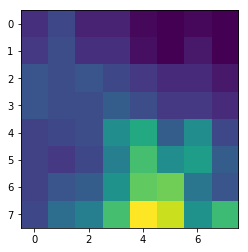

In [83]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data)
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data)
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[0].reshape(8,8))

### CNN model

In [115]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Dense(units=128, activation='relu', input_shape=(64,)))
model.add(layers.Dense(units=128, activation='relu', input_shape=(64,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 387       
Total params: 25,219
Trainable params: 25,219
Non-trainable params: 0
_________________________________________________________________


In [116]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

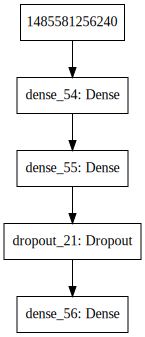

In [117]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [118]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 48 samples, validate on 24 samples
Epoch 1/30
48/48 [==============================] - 1s 23ms/step - loss: 1.2053 - acc: 0.3333 - val_loss: 0.8832 - val_acc: 0.7083
Epoch 2/30
48/48 [==============================] - 0s 257us/step - loss: 0.8930 - acc: 0.6042 - val_loss: 0.7991 - val_acc: 0.7917
Epoch 3/30
48/48 [==============================] - 0s 294us/step - loss: 0.7518 - acc: 0.7708 - val_loss: 0.7374 - val_acc: 0.7500
Epoch 4/30
48/48 [==============================] - 0s 362us/step - loss: 0.6952 - acc: 0.7917 - val_loss: 0.6773 - val_acc: 0.7500
Epoch 5/30
48/48 [==============================] - 0s 270us/step - loss: 0.5772 - acc: 0.7917 - val_loss: 0.6045 - val_acc: 0.7917
Epoch 6/30
48/48 [==============================] - 0s 270us/step - loss: 0.6564 - acc: 0.7708 - val_loss: 0.5786 - val_acc: 0.8333
Epoch 7/30
48/48 [==============================] - 0s 187us/step - loss: 0.5608 - acc: 0.8542 - val_loss: 0.5719 - val_acc: 0.7917
Epoch 8/30
48/48 [===============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


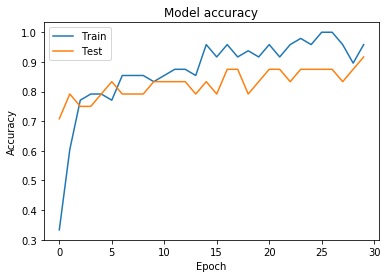

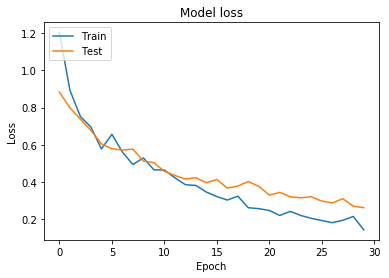

In [119]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [89]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [90]:
del model
model = models.load_model(filename)

## Confirmation

In [91]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(48, 64)

In [92]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [93]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [94]:
class_labels

['paper', 'rock', 'scissors']

In [95]:
(activations[-1][:10]*100).astype(int)

array([[ 3, 14, 81],
       [76, 20,  2],
       [41, 51,  6],
       [34, 60,  5],
       [62, 27, 10],
       [88,  9,  1],
       [ 4, 12, 83],
       [ 5, 12, 82],
       [13, 83,  3],
       [11, 67, 20]])

In [96]:
test_labels[:10].astype(int)

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])